In [1]:
import os
import json
import plistlib

import numpy as np
import pandas as pd

from PIL import Image, ImageDraw

In [2]:
with open("./PredictionExample.plist", "rb") as f:
    preds_coreml = pd.DataFrame(plistlib.load(f))

In [3]:
preds_coreml.head()

,bboxes,confidences,file
0,"[[0.3210768699645996, 0.6617439985275269, 0.56...",[1.0],file:///Users/vovacher/Downloads/CelebA/images...
1,"[[0.16135810315608978, 0.7652032375335693, 0.3...",[1.0],file:///Users/vovacher/Downloads/CelebA/images...
2,"[[0.15893451869487762, 0.751345694065094, 0.23...",[1.0],file:///Users/vovacher/Downloads/CelebA/images...
3,"[[0.45649275183677673, 0.691382646560669, 0.72...",[1.0],file:///Users/vovacher/Downloads/CelebA/images...
4,"[[0.4321293234825134, 0.6470205187797546, 0.72...",[1.0],file:///Users/vovacher/Downloads/CelebA/images...


In [4]:
(preds_coreml["confidences"].apply(len) == 1).mean()

1.0

In [5]:
preds_coreml["file"] = preds_coreml["file"].str[7:]
preds_coreml["image_id"] = preds_coreml["file"].str.split("/").str[-1]
preds_coreml["x1_coreml"] = preds_coreml["bboxes"].str[0].str[0]
preds_coreml["x2_coreml"] = preds_coreml["bboxes"].str[0].str[1]
preds_coreml["y1_coreml"] = 1 - preds_coreml["bboxes"].str[0].str[3]
preds_coreml["y2_coreml"] = 1 - preds_coreml["bboxes"].str[0].str[2]
preds_coreml["image_id"] = preds_coreml["file"].str.split("/").str[-1]
preds_coreml = preds_coreml[["image_id", "x1_coreml", "x2_coreml", "y1_coreml", "y2_coreml"]]

In [6]:
preds_coreml.head()

,image_id,x1_coreml,x2_coreml,y1_coreml,y2_coreml
0,183717.jpg,0.321077,0.661744,0.157958,0.435942
1,187377.jpg,0.161358,0.765203,0.238840,0.676628
2,199613.jpg,0.158935,0.751346,0.306500,0.769765
3,185776.jpg,0.456493,0.691383,0.133026,0.277875
4,184333.jpg,0.432129,0.647021,0.132902,0.276163


In [7]:
trues = pd.read_csv("./AnnotationExample.csv")

In [8]:
trues.head()

,image_id,x_1,y_1,width,height
0,183140.jpg,34,59,138,191
1,183170.jpg,109,53,83,115
2,183178.jpg,65,82,208,288
3,183383.jpg,330,144,172,238
4,183439.jpg,851,235,437,605


In [9]:
trues["x1_true"] = trues["x_1"]
trues["y1_true"] = trues["y_1"]
trues["x2_true"] = trues["x_1"] + trues["width"]
trues["y2_true"] = trues["y_1"] + trues["height"]
trues = trues[["image_id", "x1_true", "x2_true", "y1_true", "y2_true"]]

In [10]:
trues.head()

,image_id,x1_true,x2_true,y1_true,y2_true
0,183140.jpg,34,172,59,250
1,183170.jpg,109,192,53,168
2,183178.jpg,65,273,82,370
3,183383.jpg,330,502,144,382
4,183439.jpg,851,1288,235,840


In [11]:
merged = pd.merge(preds_coreml, trues, on="image_id", how="inner", suffixes=("_coreml", "_true"))
merged = merged.sort_values("image_id")

In [12]:
merged.head()

,image_id,x1_coreml,x2_coreml,y1_coreml,y2_coreml,x1_true,x2_true,y1_true,y2_true
62,183140.jpg,0.142802,0.787959,0.325509,0.823402,34,172,59,250
34,183170.jpg,0.350741,0.600646,0.207420,0.433255,109,192,53,168
52,183178.jpg,0.221203,0.780934,0.262784,0.644520,65,273,82,370
68,183383.jpg,0.378425,0.548076,0.189077,0.324862,330,502,144,382
41,183439.jpg,0.410263,0.633374,0.110653,0.261700,851,1288,235,840


In [13]:
base_path = "/Users/vovacher/Downloads/CelebA/images/img_celeba.7z/img_celeba/"

In [14]:
i = 5

Green = GT
Red   = CoreML


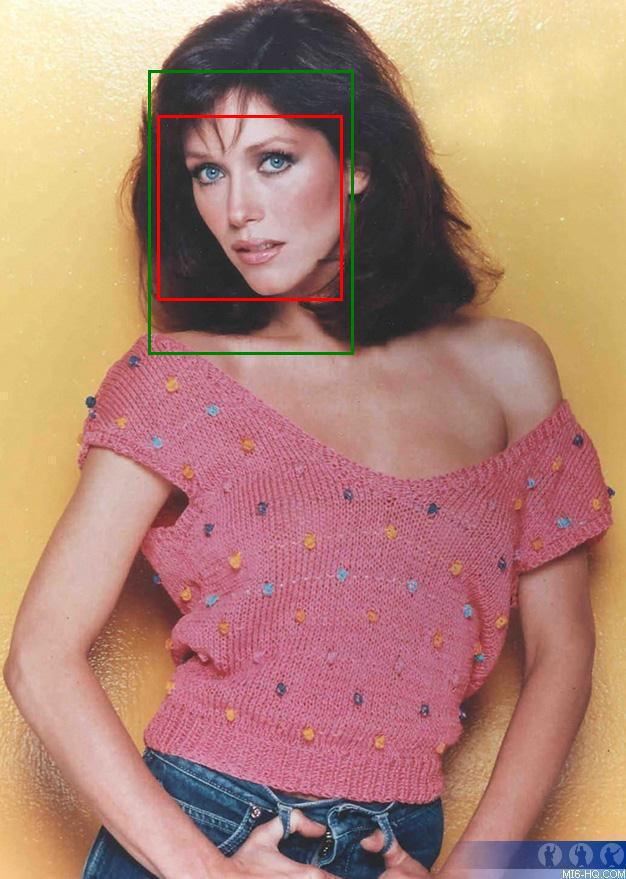

In [15]:
img = Image.open(os.path.join(base_path, merged.iloc[i]["image_id"]))
draw = ImageDraw.Draw(img)
draw.rectangle(((merged.iloc[i]["x1_true"], merged.iloc[i]["y1_true"]), 
                (merged.iloc[i]["x2_true"], merged.iloc[i]["y2_true"])), 
               outline="green", width=3)
draw.rectangle(((merged.iloc[i]["x1_coreml"] * img.size[0], merged.iloc[i]["y1_coreml"] * img.size[1]),
                (merged.iloc[i]["x2_coreml"] * img.size[0], merged.iloc[i]["y2_coreml"] * img.size[1])),
               outline="red", width=3)
print("Green = GT\nRed   = CoreML")
img

In [16]:
def get_iou(boxes1, boxes2):

    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)

    xa = np.maximum(x11, np.transpose(x21))
    ya = np.maximum(y11, np.transpose(y21))
    xb = np.minimum(x12, np.transpose(x22))
    yb = np.minimum(y12, np.transpose(y22))

    inter_area = np.maximum((xb - xa + 1), 0) * np.maximum((yb - ya + 1), 0)

    box_a_area = (x12 - x11 + 1) * (y12 - y11 + 1)
    box_b_area = (x22 - x21 + 1) * (y22 - y21 + 1)

    iou = inter_area / (box_a_area + np.transpose(box_b_area) - inter_area)
    return iou

In [17]:
def foo(x):
    img = Image.open(os.path.join(base_path, x["image_id"]))
    iou_coreml = get_iou(np.array([[x["x1_true"], x["y1_true"], 
                                    x["x2_true"], x["y2_true"]]]), 
                         np.array([[x["x1_coreml"] * img.size[0], x["y1_coreml"] * img.size[1], 
                                    x["x2_coreml"] * img.size[0], x["y2_coreml"] * img.size[1]]]))[0][0]
    return iou_coreml

In [18]:
merged["iou_coreml"] = merged.apply(foo, axis=1)

In [19]:
merged["iou_coreml"].mean()

0.608706096037234